In [1]:
import numpy as N
import lookup
import itam
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

You first need to provide a couple of txt files for the lookup table of the inverse CDF, and one for the lookup table of the target power spectrum. You also need to provide a rescaling factor to match the cell-density variance of the distribution to the variance computed from the power spectrum.

Examples of such files are in the folder 'data_itam/'. They were written by using the module lookup.py module

The function *lookup_Pk* writes the lookup table of the target nonlinear power spectrum with Planck cosmology using CLASS (you can easily modify the parameters directly inside the function).

The function *lookup_ppf* writes the target inverse CDF (percentile point function) of the simulation. In my case density.npy is the binary file containing the density of the simulation. It also save the rescale factor to match the cell-density variance of the distribution to the variance from the power spectrum.

In [4]:
lookup.lookup_Pk(cosmology='planck',nonlinear=1)
lookup.lookup_ppf(nsamples=100000, boxsize=256.0, Rth=1.0,density='data_itam/density.npy', pathpk='data_itam/planck_pk.txt',  saveto_ppf='data_itam/_ppf.txt',
        saveto_rescale='data_itam/rescale_factor.txt')

saving data_itam/planck_pk.txt
saving data_itam/_ppf.txt
cell density variance= 7.855801787462728 theoretical expected variance 9.705797447884882
ratio= 0.8093927191087931
saving data_itam/rescale_factor.txt


/home/federico/Documenti/PhD/github_public/ITAM/lookup.py:154: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sigma2, _ = quad(integrand, k_min, k_max, args = args, epsabs = 1e-08, epsrel = 1e-08, limit = 100)


In [5]:
itm = itam.ITAM(boxsize=256.,ng=256, beta=1.,Rth=1.,eps=0.001,Deps=0.001,
            pathto_pk='data_itam/planck_pk.txt',pathto_ppf = 'data_itam/_ppf.txt',saveto='data_itam/',
            pathto_rescale='data_itam/rescale_factor.txt' , plotty=0)

iteration = 1
eps = 0.74528 Deps =0.34177
iteration = 2
eps = 0.34733 Deps =1.14575
iteration = 3
eps = 0.15233 Deps =1.28010
iteration = 4
eps = 0.06962 Deps =1.18789
iteration = 5
eps = 0.03803 Deps =0.83090
iteration = 6
eps = 0.02567 Deps =0.48156
iteration = 7
eps = 0.02000 Deps =0.28307
iteration = 8
eps = 0.01678 Deps =0.19190
iteration = 9
eps = 0.01458 Deps =0.15139
iteration = 10
eps = 0.01289 Deps =0.13043
iteration = 11
eps = 0.01156 Deps =0.11589
iteration = 12
eps = 0.01046 Deps =0.10477
iteration = 13
eps = 0.00955 Deps =0.09554
iteration = 14
eps = 0.00878 Deps =0.08729
iteration = 15
eps = 0.00814 Deps =0.07940
iteration = 16
eps = 0.00759 Deps =0.07234
iteration = 17
eps = 0.00711 Deps =0.06660
iteration = 18
eps = 0.00670 Deps =0.06121
iteration = 19
eps = 0.00634 Deps =0.05654
iteration = 20
eps = 0.00602 Deps =0.05301
iteration = 21
eps = 0.00574 Deps =0.04953
iteration = 22
eps = 0.00548 Deps =0.04653
iteration = 23
eps = 0.00525 Deps =0.04378
iteration = 24
eps =

#### changing $\beta$

In this case, changing from $\beta=1$ to $\beta=1.5$ helps a lot for the convergence


In [50]:
itm = itam.ITAM(boxsize=256.,ng=256, beta=1.5,Rth=1.,eps=0.001,Deps=0.001,
            pathto_pk='data_itam/planck_pk.txt',pathto_ppf = 'data_itam/_ppf.txt',saveto='data_itam/',
            pathto_rescale='data_itam/rescale_factor.txt' , plotty=0)

iteration = 1
eps = 0.74528 Deps =0.34177
iteration = 2
eps = 0.03570 Deps =19.87460
iteration = 3
eps = 0.03602 Deps =0.00874
iteration = 4
eps = 0.02295 Deps =0.56913
iteration = 5
eps = 0.01837 Deps =0.24969
iteration = 6
eps = 0.01440 Deps =0.27536
iteration = 7
eps = 0.01218 Deps =0.18266
iteration = 8
eps = 0.01037 Deps =0.17415
iteration = 9
eps = 0.00909 Deps =0.14091
iteration = 10
eps = 0.00806 Deps =0.12725
iteration = 11
eps = 0.00728 Deps =0.10741
iteration = 12
eps = 0.00664 Deps =0.09621
iteration = 13
eps = 0.00613 Deps =0.08397
iteration = 14
eps = 0.00569 Deps =0.07675
iteration = 15
eps = 0.00532 Deps =0.06925
iteration = 16
eps = 0.00500 Deps =0.06415
iteration = 17
eps = 0.00473 Deps =0.05790
iteration = 18
eps = 0.00448 Deps =0.05632
iteration = 19
eps = 0.00425 Deps =0.05399
iteration = 20
eps = 0.00403 Deps =0.05307
iteration = 21
eps = 0.00383 Deps =0.05294
iteration = 22
eps = 0.00364 Deps =0.05255
iteration = 23
eps = 0.00345 Deps =0.05401
iteration = 24
eps 

It took $20$ iterations less than $\beta=1$ case

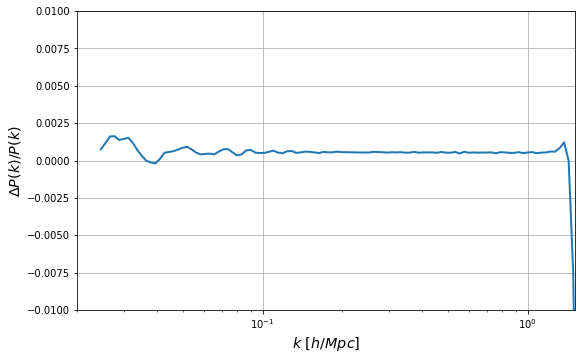

In [47]:
plt.figure(figsize=(1.62*5.5,5.5))
with warnings.catch_warnings():
    warnings.simplefilter( "ignore" , category = RuntimeWarning )
    plt.semilogx(itm.k,(itm.pk-itm.pk_ng)/itm.pk,lw=2.)
plt.ylim([-0.01,0.01])
plt.xlim([0.02,1.5])
plt.xlabel('$k \ [h/Mpc]$',fontsize='x-large')
plt.ylabel(r'$\Delta P(k)/P(k)$',fontsize='x-large')
plt.grid()
plt.show()

#### many realizations

In [8]:
from multiprocessing import cpu_count
print(cpu_count())

itm.make_covariance(nreal=100,parallel=1,cores=4)

8
making 100 realizations
saving data_itam/kbins.txt
implementing parallel execution with 4 cores
spent 12.336547986666362 minutes
0.12336547986666363 minutes per realization
saving data_itam/psvals_g.txt
saving data_itam/psvals_ng.txt


0

In [32]:
kbins = N.loadtxt('data_itam/kbins.txt')
kk,pk = N.loadtxt('data_itam/planck_pk.txt')
psvals = N.loadtxt('data_itam/psvals_ng.txt').T
psvals_g = N.loadtxt('data_itam/psvals_g.txt').T
meanPk = N.mean(psvals,axis=1)
sigmaPk = N.std(psvals,axis=1)

meanPk_g = N.mean(psvals_g,axis=1)
sigmaPk_g = N.std(psvals_g,axis=1)

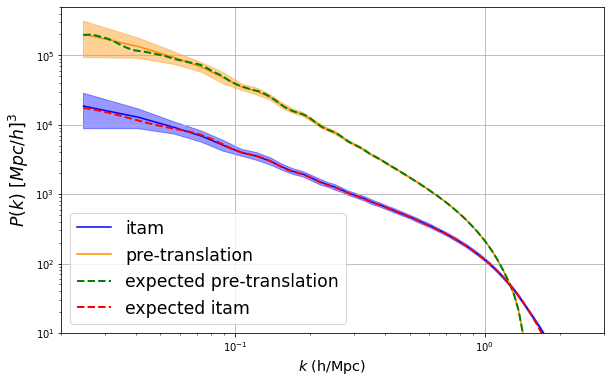

In [43]:
fig, ax = plt.subplots(figsize=(6*1.62,6))

ax.plot(kbins,meanPk,label='itam',c='b')
ax.plot(kbins,meanPk_g,label='pre-translation',c='darkorange')

ax.fill_between(kbins,meanPk_g+sigmaPk_g,meanPk_g-sigmaPk_g,alpha=0.4,color='darkorange')
ax.fill_between(kbins,meanPk+sigmaPk,meanPk-sigmaPk,alpha=0.4,color='b')
ax.plot(itm.k,itm.pk_g,'--g',label='expected pre-translation',lw=2.0)
ax.plot(itm.k,itm.pk,'--r',label='expected itam',lw=2.0)
ax.set_xlabel(r'$k$ (h/Mpc)',size='x-large')
ax.set_ylabel(r'$P(k)$ $(Mpc/h)^3$',size='large')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize='xx-large')
ax.set_ylabel('$P(k) \ [Mpc/h]^3$',fontsize='xx-large')
ax.set_ylim([10.,5e+05])
ax.set_xlim([0.02,3.])
ax.grid()

#### covariance matrix

In [22]:
kb = N.loadtxt('data_itam/kbins.txt')
ps = N.loadtxt('data_itam/psvals_ng.txt').T
print(ps.shape)
pscorr = N.corrcoef(ps)
w = kb<0.8
pscorr = pscorr[:,w]
pscorr = pscorr[w,:]
kw = kb[w]

(192, 100)


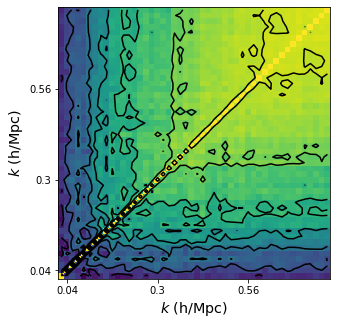

In [46]:
fig,ax1 = plt.subplots(figsize=(5,5))
ax1.imshow(pscorr,origin='lower')
ax1.contour(pscorr,colors='k')
ax1.set_xticks(N.arange(len(kw))[1::16])
ax1.set_yticks(N.arange(len(kw))[1::16])
ax1.set_xticklabels(labels=N.round(kw[1::16],decimals=2))
ax1.set_yticklabels(labels=N.round(kw[1::16],decimals=2))
ax1.set_xlabel(r'$k$ (h/Mpc)',size='x-large')
ax1.set_ylabel(r'$k$ (h/Mpc)',size='x-large')
plt.show()